### Урок 4. Деревья решений

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import combinations

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [ ]:
x = X[2,:]
print(x)
print(y)
print(x >= 1000)
print(y[x >= 1000])
right_1 = (y[x >= 1000] == 0)
right_2 = (y[x >= 1000] == 1)
print('Нулей:', right_1.sum(), 'единиц:', right_2.sum())

[ 500.  700.  750.  600. 1450.  800. 1500. 2000.  450. 1000.]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
[False False False False  True False  True  True False  True]
[1. 1. 0. 1.]
Нулей: 1 единиц: 3


In [ ]:
def calc_gini(x, y, t):
    qty_all = len(y)
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    # Индекс Джини не будет равен бесконечности в таком случае,
    # но и считать его особо смысла нет, так как получается только одна ветвь
    if qty_left == 0 or qty_right == 0:
        return np.inf

    qty0_left = ((y[x < t]) == 0).sum()
    qty0_right = ((y[x >= t]) == 0).sum()

    p0_left = qty0_left / qty_left
    p1_left = 1 - p0_left

    p0_right = qty0_right / qty_right
    p1_right = 1 - p0_right

    # Нормировочный коэффициент для левого листа
    left_coef = qty_left / qty_all

    # Индекс Джини для левого листа
    h_left = p0_left * (1 - p0_left) + p1_left * (1 - p1_left)
    # Индекс Джини для правого листа
    h_right = p0_right * (1 - p0_right) + p1_right * (1 - p1_right)

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

In [ ]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity, classes

In [ ]:
print(y[x >= 1000])
i, c = gini(y[x >= 1000])
print(i, c)

print(y[x < 1000])
i, c = gini(y[x < 1000])
print(i, c)

[1. 1. 0. 1.]
0.375 {1.0: 3, 0.0: 1}
[0. 0. 1. 0. 0. 1.]
0.4444444444444445 {0.0: 4, 1.0: 2}


In [ ]:
# Расчёт прироста качества при разбиении вершины дерева

def quality_0(left_labels, right_labels):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    gini_left, _ = gini(left_labels)
    gini_right, _ = gini(right_labels)
    
    return p * gini_left + (1 - p) * gini_right

In [ ]:
for t in x:
    print('Порог: {}, gini = {} ({})'.format(t, calc_gini(x, y, t), quality_0(y[x < t], y[x >= t])))

Порог: 500.0, gini = 0.4444444444444444 (0.4444444444444444)
Порог: 700.0, gini = 0.47619047619047616 (0.47619047619047616)
Порог: 750.0, gini = 0.4166666666666667 (0.4166666666666667)
Порог: 600.0, gini = 0.5 (0.5)
Порог: 1450.0, gini = 0.47619047619047616 (0.4761904761904763)
Порог: 800.0, gini = 0.48 (0.48)
Порог: 1500.0, gini = 0.5 (0.5)
Порог: 2000.0, gini = 0.4444444444444444 (0.4444444444444444)
Порог: 450.0, gini = inf (0.5)
Порог: 1000.0, gini = 0.4166666666666667 (0.4166666666666667)


## Практическое задание

1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.
2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [2]:
# сгенерируем данные
X, y = datasets.make_classification(n_samples=1300, n_features = 5, n_informative = 2, n_classes = 2, n_redundant=0, 
                                    n_clusters_per_class=1, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, shuffle=True, stratify=y, random_state=42)

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict_classification()  # y_pred
        self.prediction_reg = self.predict_regression()
        
    def predict_classification(self):
        try: # as np.bincount do not work with regression (assuming we train for class. and reg. tasks at one time)
            counts = np.bincount(self.labels)
            return np.argmax(counts)
        except TypeError:
            return None

    def predict_regression(self):
        return np.mean(self.labels)        

In [5]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = np.bincount(labels)
    impurity = 1     # "impurity" - "нечистота", степень неопределённости
    impurity -= np.sum(np.power(classes / len(labels), 2))
        
    return impurity

def reg_pure(labels):
    return np.var(labels)  # np.power(labels-labels.mean(),2).sum()/len(labels)

In [6]:
# Расчёт качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

def quality_reg(left_labels, right_labels, current_reg):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_reg - p * reg_pure(left_labels) - (1 - p) * reg_pure(right_labels)

In [7]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    max_features = 1.

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = int(max_features * data.shape[1])
    features_idx_to_use = np.arange(n_features) if max_features == 1 else np.random.randint(0, n_features, size=n_features)

    for index in features_idx_to_use:

        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:

            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [9]:
# Построение дерева посредством рекурсивной функции

def build_tree(data, labels, current_depth=1, max_depth=5, min_sample_split=50):
    if data.shape[0] < min_sample_split:
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    elif current_depth >= max_depth:
        return Leaf(data, labels)

    current_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, current_depth=current_depth, max_depth=max_depth)
    false_branch = build_tree(false_data, false_labels, current_depth=current_depth, max_depth=max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [12]:
tree = build_tree(X_train, y_train)

train_pred = predict(X_train, tree)
test_pred = predict(X_test, tree)

print(classification_report(y_train, train_pred, digits=3))
print(classification_report(y_test, test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.992     0.966     0.979       500
           1      0.967     0.992     0.979       500

    accuracy                          0.979      1000
   macro avg      0.979     0.979     0.979      1000
weighted avg      0.979     0.979     0.979      1000

              precision    recall  f1-score   support

           0      1.000     0.960     0.980       150
           1      0.962     1.000     0.980       150

    accuracy                          0.980       300
   macro avg      0.981     0.980     0.980       300
weighted avg      0.981     0.980     0.980       300



In [13]:
sk_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, max_features=1., min_samples_split=50)

sk_tree.fit(X_train, y_train)
sk_train_pred = sk_tree.predict(X_train)
sk_test_pred = sk_tree.predict(X_test)

print(classification_report(y_train, sk_train_pred, digits=3))
print(classification_report(y_test, sk_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.992     0.966     0.979       500
           1      0.967     0.992     0.979       500

    accuracy                          0.979      1000
   macro avg      0.979     0.979     0.979      1000
weighted avg      0.979     0.979     0.979      1000

              precision    recall  f1-score   support

           0      1.000     0.960     0.980       150
           1      0.962     1.000     0.980       150

    accuracy                          0.980       300
   macro avg      0.981     0.980     0.980       300
weighted avg      0.981     0.980     0.980       300



In [14]:
# сгенерируем данные
X, y = datasets.make_regression(n_samples=1300, n_features=5, n_informative=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, shuffle=True, random_state=42)

In [15]:
class DecisionTreeReg(BaseEstimator, ClassifierMixin):
    def __init__(self, min_samples_split=50, min_samples_leaf=5, max_features=1., max_depth=5):
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.max_depth = max_depth
        self.tree = None

    def calc_impurity(self, labels):
        return np.var(labels)

    def quality(self, left_labels, right_labels, current):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current - p * self.calc_impurity(left_labels) - (1 - p) * self.calc_impurity(right_labels)

    def split(self, data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels

    def find_best_split(self, data, labels):
    
        current = self.calc_impurity(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = int(self.max_features * data.shape[1])
        #indices = np.arange(n_features) if self.max_features == 1 else np.random.randint(0, n_features, size=n_features)

        # searching for best split through selecting best feature subset of length [n_features,]
        for indices in combinations(np.arange(data.shape[1]), r=n_features):  # more computationaly complex
        #for index in indices:  # to use random n_features to look for best split - unindent two for-loops below
            for index in indices:

                t_values = np.unique([row[index] for row in data])
        
                for t in t_values:

                    true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

                    if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                        continue
            
                    current_quality = self.quality(true_labels, false_labels, current)
            
                    if current_quality > best_quality:
                        best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels, current_depth=1, max_depth=None):

        if data.shape[0] < self.min_samples_split:
            return Leaf(data, labels)

        quality, t, index = self.find_best_split(data, labels)

        if quality == 0:
            return Leaf(data, labels)
        elif current_depth >= self.max_depth:
            return Leaf(data, labels)

        current_depth += 1

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        true_branch = self.build_tree(true_data, true_labels, current_depth=current_depth, max_depth=self.max_depth)
        false_branch = self.build_tree(false_data, false_labels, current_depth=current_depth, max_depth=self.max_depth)

        return Node(index, t, true_branch, false_branch)

    def predict_one_value(self, obj, node):

        if isinstance(node, Leaf):
            answer = node.prediction_reg
            return answer

        if obj[node.index] <= node.t:
            return self.predict_one_value(obj, node.true_branch)
        else:
            return self.predict_one_value(obj, node.false_branch)

    def fit(self, X, y=None):
        self.tree = self.build_tree(X, y)
        return self

    def predict(self, X):
        values = []
        for obj in X:
            prediction = self.predict_one_value(obj, self.tree)
            values.append(prediction)
        return np.array(values)

    def __str__(self):
        def plot_tree(node, spacing=""):
            if isinstance(node, Leaf):
                print('{} "Прогноз:", {}'.format(spacing, node.prediction_reg))
                return

            print(spacing + 'Индекс', str(node.index))
            print(spacing + 'Порог', str(node.t))

            print(spacing + '--> True:')
            plot_tree(node.true_branch, spacing + "  ")

            print(spacing + '--> False:')
            plot_tree(node.false_branch, spacing + "  ")
        plot_tree(self.tree, spacing="")
        return ''

In [16]:
tree = DecisionTreeReg(max_features=0.4) # as only 2 of 5 features are informative we can decrease max_features

tree.fit(X_train, y_train)
train_pred = tree.predict(X_train)
test_pred = tree.predict(X_test)

print(f'RMSE train: {mean_squared_error(y_train, train_pred, squared=False):.4f}')
print(f'RMSE test: {mean_squared_error(y_test, test_pred, squared=False):.4f}')

print(f'R^2 train: {r2_score(y_train, train_pred):.4f}')
print(f'R^2 test: {r2_score(y_test, test_pred):.4f}')

RMSE train: 21.3397
RMSE test: 23.4345
R^2 train: 0.9205
R^2 test: 0.9059


In [17]:
print(tree)

Индекс 0
Порог 0.269294752580734
--> True:
  Индекс 0
  Порог -0.6067002947652967
  --> True:
    Индекс 0
    Порог -1.5255251709247388
    --> True:
      Индекс 4
      Порог -0.07022036151761657
      --> True:
         "Прогноз:", -168.66400545161866
      --> False:
         "Прогноз:", -109.69161588475853
    --> False:
      Индекс 4
      Порог 0.44194064956940904
      --> True:
         "Прогноз:", -83.1084832457409
      --> False:
         "Прогноз:", -29.182558333989274
  --> False:
    Индекс 4
    Порог 0.3686733088729012
    --> True:
      Индекс 4
      Порог -0.48712538376469605
      --> True:
         "Прогноз:", -44.525535267855176
      --> False:
         "Прогноз:", -13.700884370049769
    --> False:
      Индекс 0
      Порог -0.32115903870570245
      --> True:
         "Прогноз:", 2.858522330297738
      --> False:
         "Прогноз:", 32.57504908576925
--> False:
  Индекс 0
  Порог 1.0114630354083562
  --> True:
    Индекс 4
    Порог -0.36961033604363397


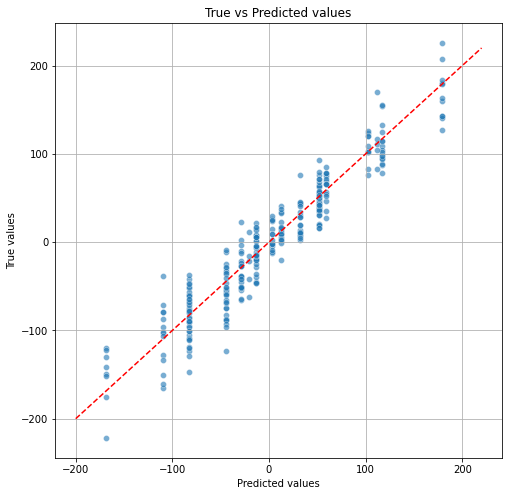

In [18]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=test_pred, y=y_test, alpha=0.6)
plt.plot([-200, 220], [-200, 220], linestyle='--', color='red')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('True vs Predicted values')
plt.grid()
plt.show()

In [19]:
sk_tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=50, max_features=.8,
                                random_state=42)

sk_tree.fit(X_train, y_train)
train_pred = sk_tree.predict(X_train)
test_pred = sk_tree.predict(X_test)

print(f'RMSE train: {mean_squared_error(y_train, train_pred, squared=False):.4f}')
print(f'RMSE test: {mean_squared_error(y_test, test_pred, squared=False):.4f}')

print(f'R^2 train: {r2_score(y_train, train_pred):.4f}')
print(f'R^2 test: {r2_score(y_test, test_pred):.4f}')

RMSE train: 19.2578
RMSE test: 23.2178
R^2 train: 0.9352
R^2 test: 0.9076


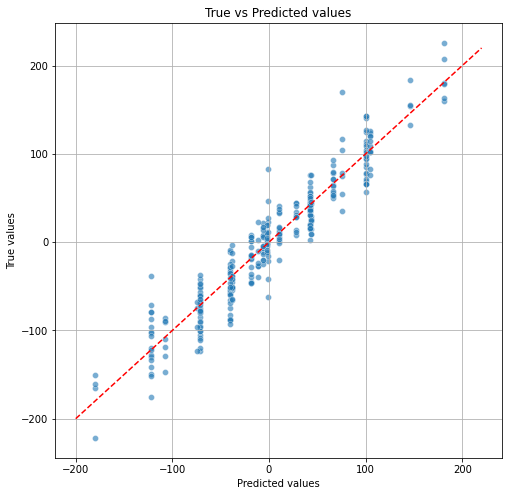

In [20]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=test_pred, y=y_test, alpha=0.6)
plt.plot([-200, 220], [-200, 220], linestyle='--', color='red')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('True vs Predicted values')
plt.grid()
plt.show()

In [203]:
from sklearn.tree import export_graphviz

In [207]:
export_graphviz(sk_tree, out_file='tree.dot', rounded=True, proportion=False, precision=2, filled=True)

In [ ]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
from IPython.display import Image
Image(filename='tree.png')